<a href="https://colab.research.google.com/github/tigerjk726/Bumjoong/blob/main/Typhoon_modeling_Korea_20221208_7~10_Ver_08(frequency).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT DATA

In [1]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')             

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/2022.10.10 typhoon

/content/drive/My Drive/Colab Notebooks/2022.10.10 typhoon


In [3]:
import pandas as pd
df = pd.read_csv('19592021korea.csv')
df

,year,mon,amo,aao,ao,emi,gmo,nino3,nino4,pdo,pna,qbo,freq,inten
0,1959,1,-0.006,-4368.947,-11420.598,0.812,-0.138,-0.046,0.014,1.266,-0.973,-27.747,0,0
1,1959,2,0.015,5669.410,23909.777,0.455,-0.160,-0.050,-0.230,0.711,-0.870,-26.219,0,0
2,1959,3,-0.081,4402.402,10543.838,0.300,-0.081,-0.117,-0.331,0.204,0.654,-20.962,0,0
3,1959,4,-0.106,26736.894,862.876,0.430,-0.108,-0.104,-0.184,0.301,-0.349,-11.294,0,0
4,1959,5,-0.146,15129.227,-1731.295,0.471,-0.153,-0.362,-0.241,0.313,-0.602,4.960,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2021,8,0.170,-1268.185,766.893,-0.376,0.348,-0.421,-0.241,-0.832,-0.014,-10.350,1,26
752,2021,9,0.261,-16800.218,-650.241,-0.435,0.404,-0.410,-0.469,-1.794,-0.074,-13.822,1,55
753,2021,10,0.291,-11055.364,262.031,-0.570,0.431,-0.707,-0.631,-2.565,-0.313,-17.170,0,0
754,2021,11,0.276,-21354.890,930.126,-0.466,0.397,-0.942,-0.600,-2.215,0.650,-19.507,0,0


칼럼별 명칭

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df.columns

Index(['year', 'mon', 'amo', 'aao', 'ao', 'emi', 'gmo', 'nino3', 'nino4',
       'pdo', 'pna', 'qbo', 'freq', 'inten'],
      dtype='object')

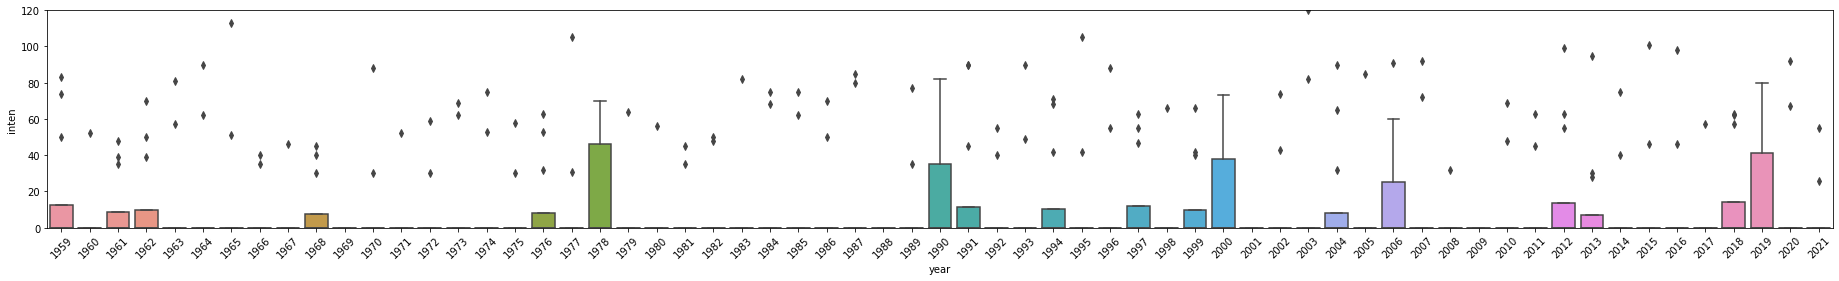

In [6]:
var = 'year'
data = pd.concat([df['inten'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(32, 4))
fig = sns.boxplot(x=var, y="inten", data=data)
fig.axis(ymin=0, ymax=120);
plt.xticks(rotation=45);

# Data Splitting


In [7]:
df = df[df["mon"].isin([6,7,8,9,10,11])]
#df2 = df[df["mon"].isin([910])]

In [ ]:
#train = df[df["year"].isin(list(range(1959,2019,1)))]

In [ ]:
#test = df[df["year"].isin(list(range(2019,2021,1)))]

In [8]:
x = df.iloc[:,1:12]
y1 = df.iloc[:,12:13]
y2 = df.iloc[:,13:]
print(y1, y2,np.mean(y1), np.mean(y2),x)

     freq
5       0
6       1
7       1
8       2
9       0
..    ...
750     0
751     1
752     1
753     0
754     0

[378 rows x 1 columns]      inten
5        0
6       50
7       83
8       74
9        0
..     ...
750      0
751     26
752     55
753      0
754      0

[378 rows x 1 columns] freq    0.455026
dtype: float64 inten    20.502646
dtype: float64      mon    amo        aao        ao    emi    gmo  nino3  nino4    pdo  \
5      6 -0.083   2899.151  -623.744  0.275 -0.138 -0.507 -0.434  0.306   
6      7 -0.130   4616.751  2605.754  0.100 -0.153 -0.786 -0.594 -0.011   
7      8 -0.022  19427.269 -3600.671  0.335 -0.172 -0.790 -0.504  0.050   
8      9  0.028  -9673.271 -1280.071  0.208 -0.244 -0.666 -0.530 -0.126   
9     10 -0.055   6261.660 -1149.088  0.143 -0.184 -0.414 -0.429  1.107   
..   ...    ...        ...       ...    ...    ...    ...    ...    ...   
750    7  0.083  -5085.878  6431.609 -0.241  0.331 -0.306 -0.203 -1.532   
751    8  0.170  -1268.185   766.8

#Modelling


In [42]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV,ElasticNet,ElasticNetCV,LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from statistics import mean

In [43]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

Logistic = LogisticRegression()
model = RandomForestClassifier(random_state=1)
model2 = RandomForestClassifier(random_state=1)

In [35]:
#Validation function

def rmsle_cv_f(model):
    cv = LeaveOneOut()
    rmse = -cross_val_score(model, x, y1, scoring="neg_mean_squared_error", cv = cv)
    return(rmse)

def rmsle_cv_f1(model):
    cv = LeaveOneOut()
    rmse= np.sqrt(-cross_val_score(model, x, y1, scoring="neg_mean_squared_error", cv = cv))
    return(rmse)

n_folds = 5
def rmsle_cv_f2(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x)
    rmse= np.sqrt(-cross_val_score(model, x, y1, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [44]:
score_m = rmsle_cv_f(model)
print("score: {:.4f}\n".format(mean(abs(score_m))))

score_m1 = rmsle_cv_f1(model)
print("score: {:.4f}\n".format(mean(abs(score_m1))))

score_m2 = rmsle_cv_f2(model)
print("score: {:.4f}\n".format(mean(abs(score_m2))))

score: 0.7407

score: 0.4656

score: 0.8490



In [45]:
score_m2 = rmsle_cv_f(model2)
print("score: {:.4f}\n".format(mean(abs(score_m2))))

score_m21 = rmsle_cv_f1(model2)
print("score: {:.4f}\n".format(mean(abs(score_m21))))

score_m22 = rmsle_cv_f2(model2)
print("score: {:.4f}\n".format(mean(abs(score_m22))))

score: 0.7407

score: 0.4656

score: 0.8490



In [46]:
score_lo2 = rmsle_cv_f(Logistic)
print("score: {:.4f}\n".format(mean(abs(score_lo2))))

score_lo21 = rmsle_cv_f1(Logistic)
print("score: {:.4f}\n".format(mean(abs(score_lo21))))

score_lo22 = rmsle_cv_f2(Logistic)
print("score: {:.4f}\n".format(mean(abs(score_lo22))))

score: 0.7804

score: 0.4577

score: 0.8760



In [47]:
from statistics import mean

score_l = rmsle_cv_f(lasso)
print("score: {:.4f}\n".format(mean(abs(score_l))))

score_l1 = rmsle_cv_f1(lasso)
print("score: {:.4f}\n".format(mean(abs(score_l1))))

score_l2 = rmsle_cv_f2(lasso)
print("score: {:.4f}\n".format(mean(abs(score_l2))))

score: 0.5578

score: 0.5572

score: 0.7391



In [48]:
score_e = rmsle_cv_f(ENet)
print("score: {:.4f}\n".format(mean(abs(score_e))))

score_e1 = rmsle_cv_f1(ENet)
print("score: {:.4f}\n".format(mean(abs(score_e1))))

score_e2 = rmsle_cv_f2(ENet)
print("score: {:.4f}\n".format(mean(abs(score_e2))))

score: 0.5579

score: 0.5572

score: 0.7391



In [49]:
score_x = rmsle_cv_f(model_xgb)
print("score_x: {:.4f}\n".format(mean(abs(score_x))))

score_x1 = rmsle_cv_f1(model_xgb)
print("score: {:.4f}\n".format(mean(abs(score_x1))))

score_x2 = rmsle_cv_f2(model_xgb)
print("score: {:.4f}\n".format(mean(abs(score_x2))))

score_x: 0.5328

score: 0.5177

score: 0.7000



In [50]:
score_g = rmsle_cv_f(model_lgb)
print("score_g: {:.4f}\n".format(mean(abs(score_g))))

score_g1 = rmsle_cv_f1(model_lgb)
print("score: {:.4f}\n".format(mean(abs(score_g1))))

score_g2 = rmsle_cv_f2(model_lgb)
print("score: {:.4f}\n".format(mean(abs(score_g2))))

score_g: 0.5034

score: 0.4990

score: 0.7012



In [52]:
df["Name"] = df["year"].apply(str) + ' ' + df["mon"].apply(str)

In [53]:
y1 = y1.set_index(df["Name"])

In [54]:
score_g1 = pd.DataFrame(score_g1)
score_g1 = score_g1.set_index(df["Name"])

In [ ]:
# Y1 = Y1.values.tolist()

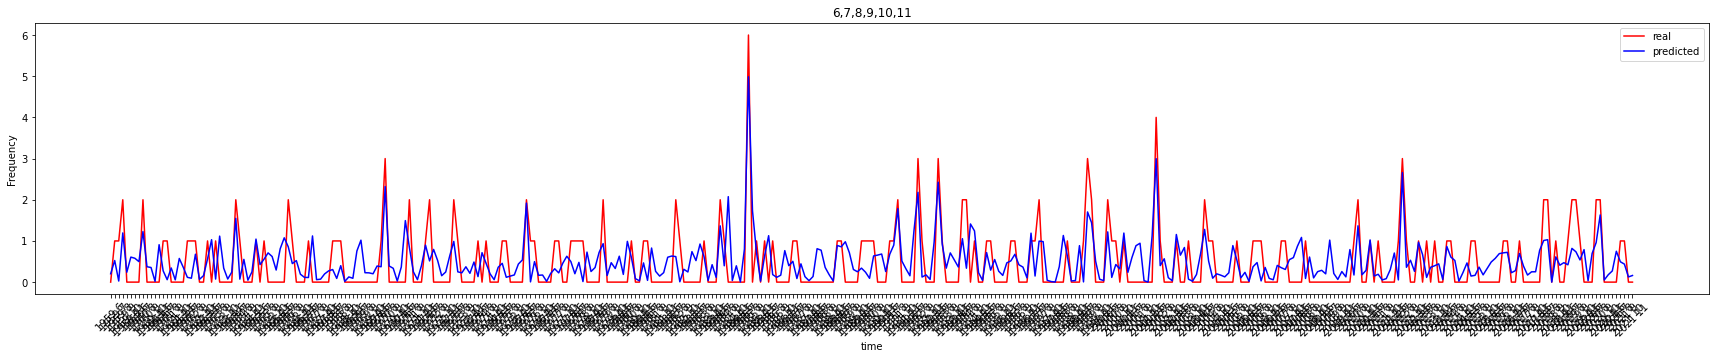

In [55]:
plt.figure(figsize=(30, 5))  

plt.plot(y1, color='red', label='real')
plt.plot(score_g1, color='blue', label='predicted')
plt.title('6,7,8,9,10,11')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [58]:
Corr = pd.merge(score_g1, y1, on='Name')
Corr.corr()

,0,freq
0,1.000000,0.603122
freq,0.603122,1.000000


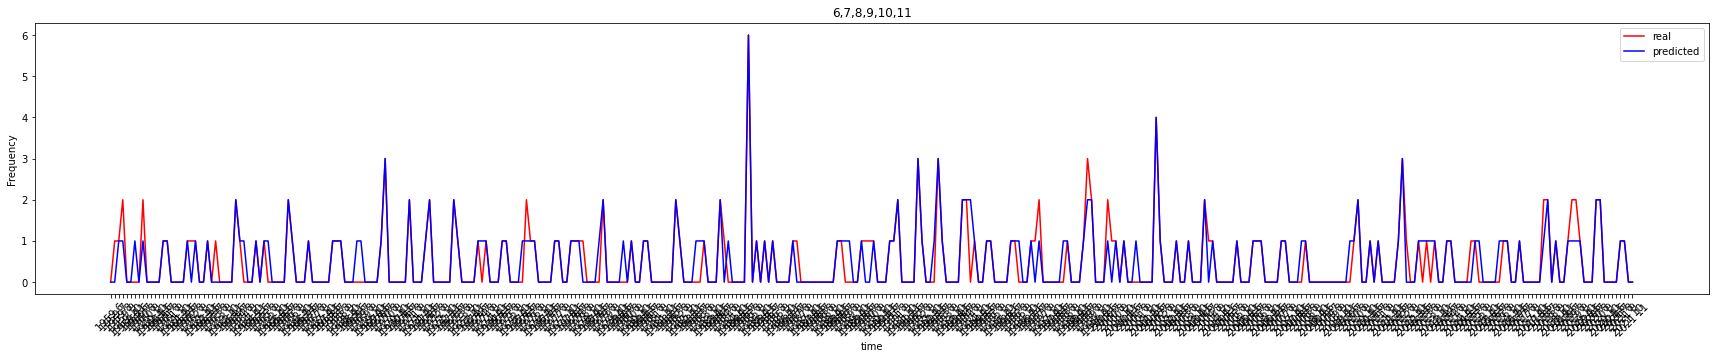

In [61]:
score_m1 = pd.DataFrame(score_m1)
score_m1 = score_m1.set_index(df["Name"])
plt.figure(figsize=(30, 5))  
plt.plot(y1, color='red', label='real')
plt.plot(score_m1, color='blue', label='predicted')
plt.title('6,7,8,9,10,11')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [62]:
Corr = pd.merge(score_m1, y1, on='Name')
Corr.corr()

,0,freq
0,1.000000,0.880072
freq,0.880072,1.000000


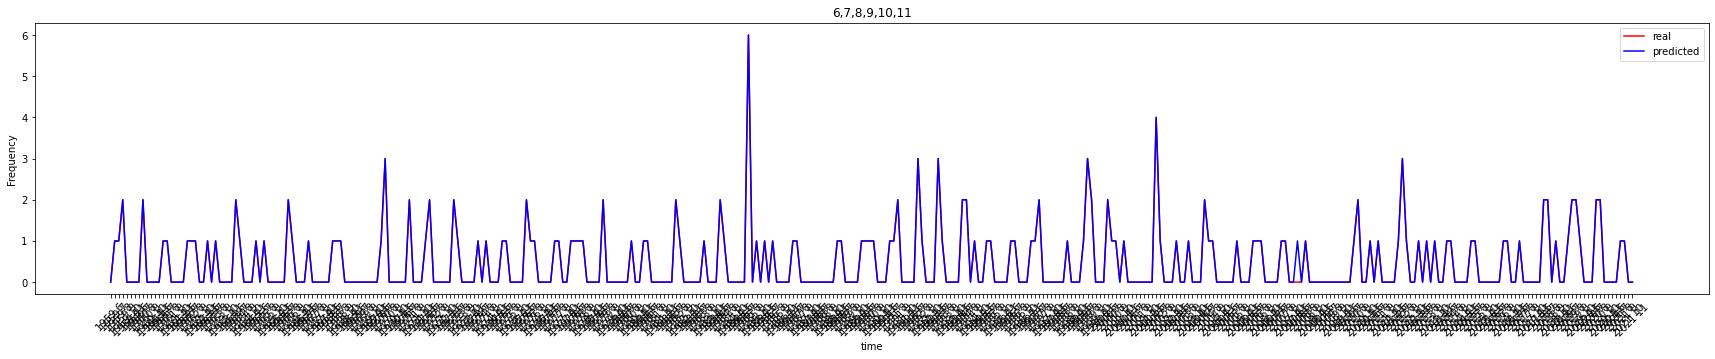

In [59]:
score_lo21 = pd.DataFrame(score_lo21)
score_lo21 = score_lo21.set_index(df["Name"])
plt.figure(figsize=(30, 5))  
plt.plot(y1, color='red', label='real')
plt.plot(score_lo21, color='blue', label='predicted')
plt.title('6,7,8,9,10,11')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [60]:
Corr = pd.merge(score_lo21, y1, on='Name')
Corr.corr()

,0,freq
0,1.000000,0.997689
freq,0.997689,1.000000


#Intensity

In [63]:
#Validation function

def rmsle_cv_i(model):
    cv = LeaveOneOut()
    rmse = -cross_val_score(model, x, y2, scoring="neg_mean_squared_error", cv = cv)
    return(rmse)

def rmsle_cv_i1(model):
    cv = LeaveOneOut()
    rmse= np.sqrt(-cross_val_score(model, x, y2, scoring="neg_mean_squared_error", cv = cv))
    return(rmse)

n_folds = 5
def rmsle_cv_i2(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x)
    rmse= np.sqrt(-cross_val_score(model, x, y2, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [64]:
score_m = rmsle_cv_i(model)
print("score: {:.4f}\n".format(mean(abs(score_m))))

score_m1 = rmsle_cv_i1(model)
print("score: {:.4f}\n".format(mean(abs(score_m1))))

score_m2 = rmsle_cv_i2(model)
print("score: {:.4f}\n".format(mean(abs(score_m2))))

score: 1339.4233

score: 20.1270

score: 36.6237



In [65]:
score_m2 = rmsle_cv_i(model2)
print("score: {:.4f}\n".format(mean(abs(score_m2))))

score_m21 = rmsle_cv_i1(model2)
print("score: {:.4f}\n".format(mean(abs(score_m21))))

score_m22 = rmsle_cv_i2(model2)
print("score: {:.4f}\n".format(mean(abs(score_m22))))

score: 1339.4233

score: 20.1270

score: 36.6237



In [66]:
score_lo2 = rmsle_cv_i(Logistic)
print("score: {:.4f}\n".format(mean(abs(score_lo2))))

score_lo21 = rmsle_cv_i1(Logistic)
print("score: {:.4f}\n".format(mean(abs(score_lo21))))

score_lo22 = rmsle_cv_i2(Logistic)
print("score: {:.4f}\n".format(mean(abs(score_lo22))))

score: 1380.7249

score: 20.5026

score: 37.2708



In [67]:
score_l = rmsle_cv_i(lasso)
print("score: {:.4f}\n".format(mean(abs(score_l))))

score_l1 = rmsle_cv_i1(lasso)
print("score: {:.4f}\n".format(mean(abs(score_l1))))

score_l2 = rmsle_cv_i2(lasso)
print("score: {:.4f}\n".format(mean(abs(score_l2))))

score: 947.2584

score: 25.4738

score: 30.6593



In [68]:
score_e = rmsle_cv_i(ENet)
print("score: {:.4f}\n".format(mean(abs(score_e))))

score_e1 = rmsle_cv_i1(ENet)
print("score: {:.4f}\n".format(mean(abs(score_e1))))

score_e2 = rmsle_cv_i2(ENet)
print("score: {:.4f}\n".format(mean(abs(score_e2))))

score: 947.2351

score: 25.4740

score: 30.6590



In [69]:
score_x = rmsle_cv_i(model_xgb)
print("score_x: {:.4f}\n".format(mean(abs(score_x))))

score_x1 = rmsle_cv_i1(model_xgb)
print("score: {:.4f}\n".format(mean(abs(score_x1))))

score_x2 = rmsle_cv_i2(model_xgb)
print("score: {:.4f}\n".format(mean(abs(score_x2))))

score_x: 874.2746

score: 22.6796

score: 30.5621



In [70]:
score_g = rmsle_cv_i(model_lgb)
print("score_g: {:.4f}\n".format(mean(abs(score_g))))

score_g1 = rmsle_cv_i1(model_lgb)
print("score: {:.4f}\n".format(mean(abs(score_g1))))

score_g2 = rmsle_cv_i2(model_lgb)
print("score: {:.4f}\n".format(mean(abs(score_g2))))

score_g: 836.7750

score: 21.8847

score: 30.7993



In [71]:
df["Name"] = df["year"].apply(str) + ' ' + df["mon"].apply(str)

In [72]:
y2 = y2.set_index(df["Name"])

In [73]:
score_g1 = pd.DataFrame(score_g1)
score_g1 = score_g1.set_index(df["Name"])

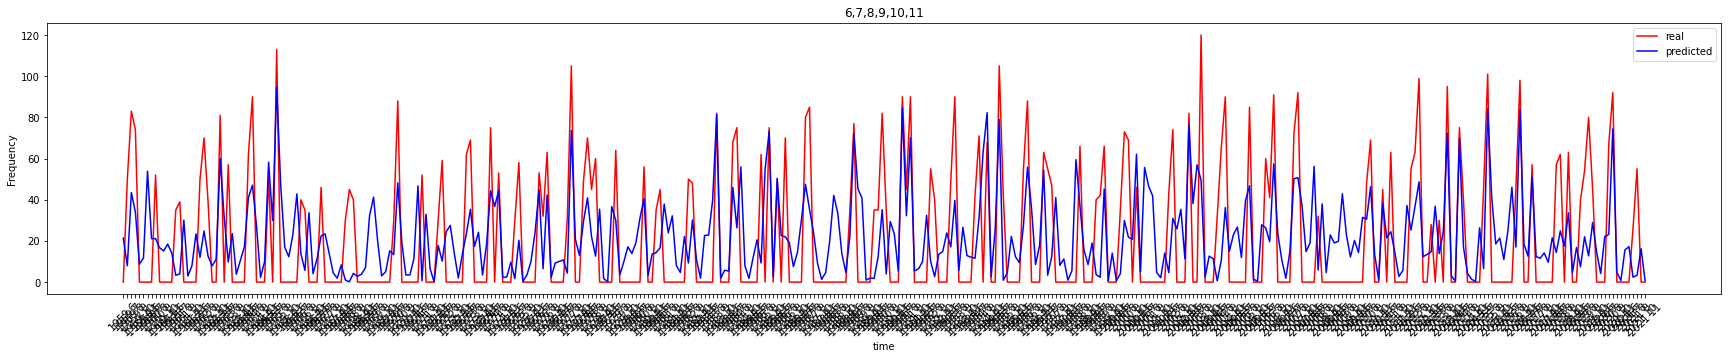

In [74]:
plt.figure(figsize=(30, 5))  

plt.plot(y2, color='red', label='real')
plt.plot(score_g1, color='blue', label='predicted')
plt.title('6,7,8,9,10,11')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [75]:
Corr = pd.merge(score_g1, y2, on='Name')
Corr.corr()

,0,inten
0,1.000000,0.528588
inten,0.528588,1.000000


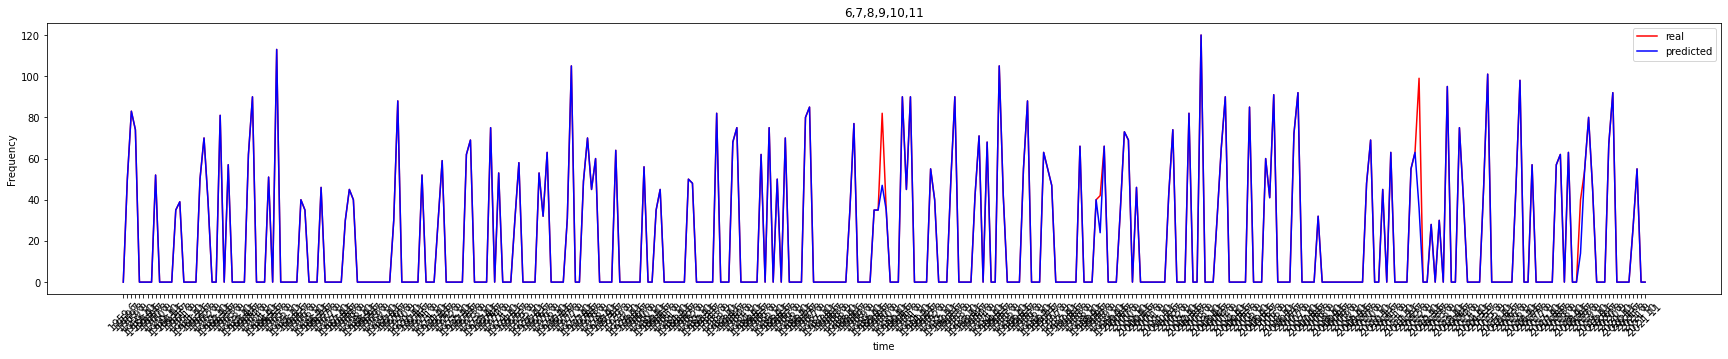

In [78]:
score_m1 = pd.DataFrame(score_m1)
score_m1 = score_m1.set_index(df["Name"])
plt.figure(figsize=(30, 5))  
plt.plot(y2, color='red', label='real')
plt.plot(score_m1, color='blue', label='predicted')
plt.title('6,7,8,9,10,11')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [79]:
Corr = pd.merge(score_m1, y2, on='Name')
Corr.corr()

,0,inten
0,1.00000,0.99152
inten,0.99152,1.00000


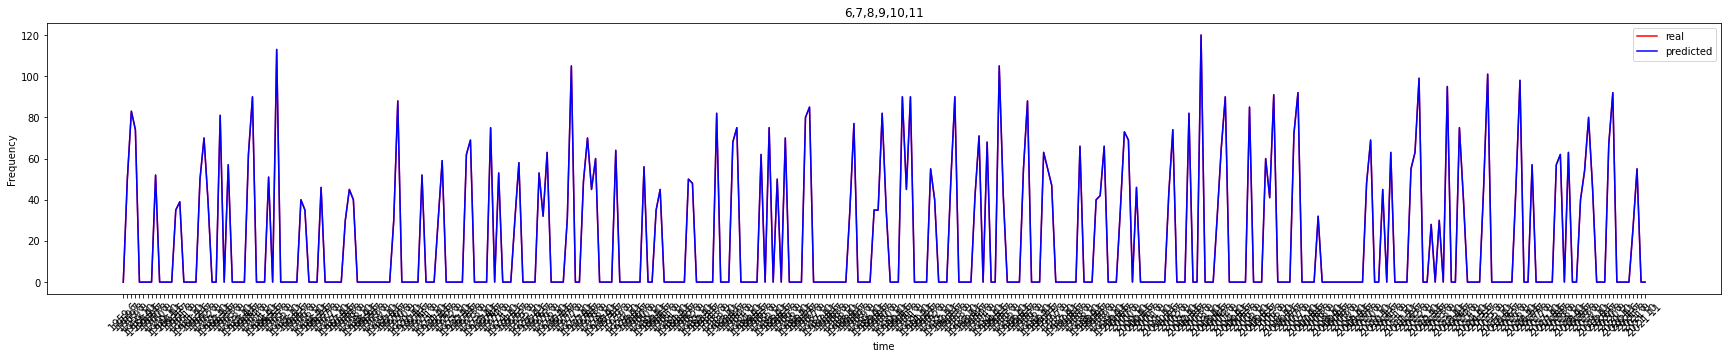

In [76]:
score_lo21 = pd.DataFrame(score_lo21)
score_lo21 = score_lo21.set_index(df["Name"])
plt.figure(figsize=(30, 5))  
plt.plot(y2, color='red', label='real')
plt.plot(score_lo21, color='blue', label='predicted')
plt.title('6,7,8,9,10,11')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [77]:
Corr = pd.merge(score_lo21, y2, on='Name')
Corr.corr()

,0,inten
0,1.0,1.0
inten,1.0,1.0
